### Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split, Subset
import os

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Define data transformations for data augmentation and normalization

In [3]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # This gives a random zoom effect
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomVerticalFlip(),    # Random vertical flip
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

### Data Loaders 

In [4]:
data_dir = 'Animals'
full_dataset = datasets.ImageFolder(data_dir)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_indices, val_indices = random_split(range(len(full_dataset)), [train_size, val_size])

# Create Subset datasets
train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)

In [5]:
train_dataset.dataset.transform = transform_train
val_dataset.dataset.transform = transform_val

In [6]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)

### Define the model

In [7]:
model = models.resnet18(pretrained=True)

# Freeze all layers except the final classification layer
for name, param in model.named_parameters():
    if "fc" in name:  # Unfreeze the final classification layer
        param.requires_grad = True
    else:
        param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3)  # 3 classes

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # Use all parameters

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

c:\Users\bimsa\.conda\envs\YOLO-ObjectDetection\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\bimsa\.conda\envs\YOLO-ObjectDetection\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Training Loop

In [8]:
accuracies = []
losses = []

num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad() # reset the optimizer
        outputs = model(inputs) # let the model to predict (forward prop)
        loss = criterion(outputs, labels) # calculate the diffrence of predictions and ground truth
        loss.backward() # backward prop
        optimizer.step() # weight updates

        running_loss += loss.item()

    losses.append(running_loss/len(train_loader))
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}')


    model.eval()
    correct, total = 0, 0

    with torch.no_grad(): # disable gradient calculations
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predicted = torch.max(outputs.data, 1)[1] # get the predicted class for each sample of the batch

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracies.append(100 * correct / total)
    print(f'Validation Accuracy: {100 * correct / total} %')

print("Training Proccess Finished")

Epoch 1/15, Loss: 0.810342535438637
Validation Accuracy: 95.0 %
Epoch 2/15, Loss: 0.5294417709112167
Validation Accuracy: 98.33333333333333 %
Epoch 3/15, Loss: 0.34866742331845063
Validation Accuracy: 98.33333333333333 %
Epoch 4/15, Loss: 0.40264745623183745
Validation Accuracy: 95.0 %
Epoch 5/15, Loss: 0.38103427454673994
Validation Accuracy: 95.0 %
Epoch 6/15, Loss: 0.3837235795877253
Validation Accuracy: 98.33333333333333 %
Epoch 7/15, Loss: 0.2998333020252176
Validation Accuracy: 98.33333333333333 %
Epoch 8/15, Loss: 0.3791073861454303
Validation Accuracy: 93.33333333333333 %
Epoch 9/15, Loss: 0.46653568399876044
Validation Accuracy: 98.33333333333333 %
Epoch 10/15, Loss: 0.2560421493641722
Validation Accuracy: 98.33333333333333 %
Epoch 11/15, Loss: 0.43692321240717624
Validation Accuracy: 98.33333333333333 %
Epoch 12/15, Loss: 0.5091753542714287
Validation Accuracy: 98.33333333333333 %
Epoch 13/15, Loss: 0.45879259698607106
Validation Accuracy: 98.33333333333333 %
Epoch 14/15, Los

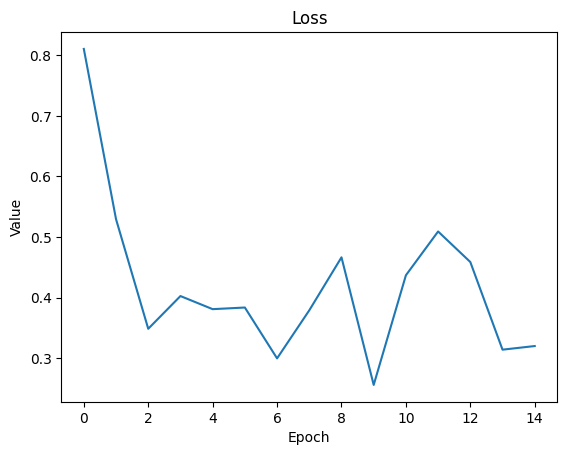

In [12]:
import matplotlib.pyplot as plt

plt.plot(losses)

plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Loss')

plt.show()

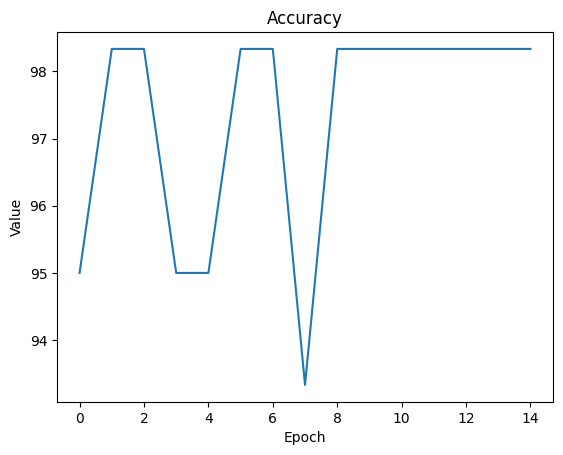

In [13]:
import matplotlib.pyplot as plt

plt.plot(accuracies)

plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Accuracy')

plt.show()

In [11]:
torch.save(model.state_dict(), 'animal_classifier.pth')

### Predictions using trained model

In [15]:
import torch
from torchvision import models, transforms
from PIL import Image

class ImagePredictor:
    def __init__(self, model_path, device, class_names):
        self.model = self.__load_model(model_path, device)
        self.device = device
        self.class_names = class_names
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __load_model(self, model_path, device):
        model = models.resnet18(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, 3)  # Adjust to match the original model's output units
        model.load_state_dict(torch.load(model_path))
        model.to(device)
        model.eval()
        return model

    def load_and_preprocess_image(self, image_path):
        image = Image.open(image_path)
        image = self.transform(image).unsqueeze(0)  # Add batch dimension
        return image.to(self.device)

    def predict(self, image_path):
        image = self.load_and_preprocess_image(image_path)
        # Make prediction
        with torch.no_grad():
            outputs = self.model(image)
            _, predicted = torch.max(outputs, 1)
        
        predicted_class = predicted.item()
        predicted_class_name = self.class_names[predicted_class]
        
        return predicted_class_name

In [28]:
# create an instance from the ImagePredictor class
model_path = 'model/animal_classifier.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class_names = ['Cat', 'Dog', 'Snake']

image_predictor = ImagePredictor(model_path, device, class_names)

Predicted class: Dog


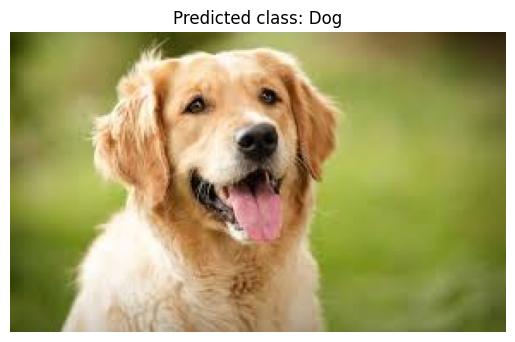

In [31]:
image_path = 'unseen images/images.jpg'
predicted_class_name = image_predictor.predict(image_path)
print(f'Predicted class: {predicted_class_name}')

image = Image.open(image_path).convert('RGB')
        
plt.imshow(image)
plt.title(f'Predicted class: {predicted_class_name}')
plt.axis('off')
plt.show()

Predicted class: Snake


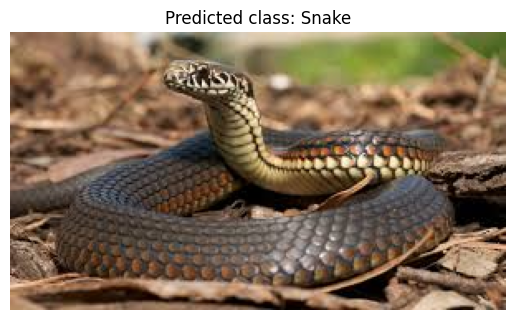

In [32]:
image_path = 'unseen images/images_2.jpg'
predicted_class_name = image_predictor.predict(image_path)
print(f'Predicted class: {predicted_class_name}')

image = Image.open(image_path).convert('RGB')
        
plt.imshow(image)
plt.title(f'Predicted class: {predicted_class_name}')
plt.axis('off')
plt.show()

Predicted class: Dog


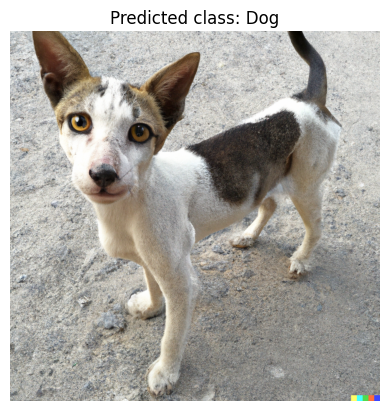

In [34]:
image_path = 'unseen images/image_3.png'
predicted_class_name = image_predictor.predict(image_path)
print(f'Predicted class: {predicted_class_name}')

image = Image.open(image_path).convert('RGB')
        
plt.imshow(image)
plt.title(f'Predicted class: {predicted_class_name}')
plt.axis('off')
plt.show()